# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.Grayscale(num_output_channels=3),
                                       transforms.RandomRotation(6),
                                       transforms.Grayscale(num_output_channels=1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.Grayscale(num_output_channels=3),
                                      #  transforms.RandomRotation(8),
                                      #  transforms.Grayscale(num_output_channels=1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


60000
[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
torch.Size([128, 1, 28, 28])
torch.Size([128])


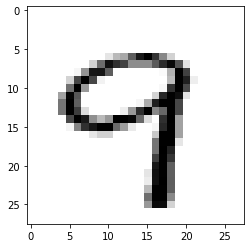

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
#train_data = train.transform(train_data.numpy())
train_data = [n[0] for n in train]
print(len(train_data))
print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train.data))
print(' - max:', torch.max(train.data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

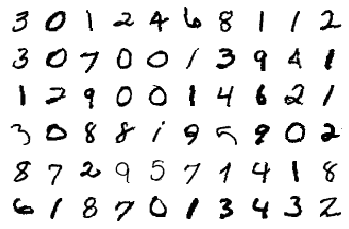

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8), 
            torch.nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16), 
            torch.nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            # nn.BatchNorm2d(24), 
            # torch.nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
           nn.BatchNorm2d(8),
           torch.nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            torch.nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=25, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(25),
            torch.nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
       #     nn.BatchNorm2d(10),
       #     torch.nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        # angle = random.choice([-30, -15, 0, 15, 30])
        # x = TF.rotate(x, angle)
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 24, 22, 22]           3,456
             ReLU-10           [-1, 24, 22, 22]               0
        MaxPool2d-11           [-1, 24, 11, 11]               0
           Conv2d-12            [-1, 8, 11, 11]             192
      BatchNorm2d-13            [-1, 8, 11, 11]              16
          Dropout-14            [-

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR
learning_rate = 0.2
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9, nesterov=True)
scheduler = StepLR(optimizer, step_size = 6, gamma = 0.1)

# Let's Train and test our model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    # Decay Learning Rate
    scheduler.step()
    # Print Learning Rate
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 0 LR: [0.2]
EPOCH: 0


Loss=0.23118333518505096 Batch_id=468 Accuracy=90.28: 100%|██████████| 469/469 [00:26<00:00, 17.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Accuracy: 9789/10000 (97.89%)

Epoch: 1 LR: [0.2]
EPOCH: 1


Loss=0.1219281554222107 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:27<00:00, 17.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9811/10000 (98.11%)

Epoch: 2 LR: [0.2]
EPOCH: 2


Loss=0.040358882397413254 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:26<00:00, 17.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9863/10000 (98.63%)

Epoch: 3 LR: [0.2]
EPOCH: 3


Loss=0.05997312441468239 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:27<00:00, 20.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9873/10000 (98.73%)

Epoch: 4 LR: [0.2]
EPOCH: 4


Loss=0.012822960503399372 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:27<00:00, 21.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9897/10000 (98.97%)

Epoch: 5 LR: [0.0020000000000000005]
EPOCH: 5


Loss=0.025547698140144348 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:27<00:00, 16.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9889/10000 (98.89%)

Epoch: 6 LR: [0.020000000000000004]
EPOCH: 6


Loss=0.04067269340157509 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:27<00:00, 17.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9905/10000 (99.05%)

Epoch: 7 LR: [0.020000000000000004]
EPOCH: 7


Loss=0.01694498024880886 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:27<00:00, 17.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)

Epoch: 8 LR: [0.020000000000000004]
EPOCH: 8


Loss=0.21636338531970978 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9912/10000 (99.12%)

Epoch: 9 LR: [0.020000000000000004]
EPOCH: 9


Loss=0.023043856024742126 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9914/10000 (99.14%)

Epoch: 10 LR: [0.020000000000000004]
EPOCH: 10


Loss=0.05881762132048607 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9917/10000 (99.17%)

Epoch: 11 LR: [0.00020000000000000006]
EPOCH: 11


Loss=0.026566365733742714 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:27<00:00, 20.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9921/10000 (99.21%)

Epoch: 12 LR: [0.0020000000000000005]
EPOCH: 12


Loss=0.06301744282245636 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

Epoch: 13 LR: [0.0020000000000000005]
EPOCH: 13


Loss=0.004821231123059988 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:27<00:00, 16.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9926/10000 (99.26%)

Epoch: 14 LR: [0.0020000000000000005]
EPOCH: 14


Loss=0.0518907755613327 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

Epoch: 15 LR: [0.0020000000000000005]
EPOCH: 15


Loss=0.03988227620720863 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:27<00:00, 16.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)

Epoch: 16 LR: [0.0020000000000000005]
EPOCH: 16


Loss=0.039826590567827225 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:27<00:00, 20.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9918/10000 (99.18%)

Epoch: 17 LR: [2.000000000000001e-05]
EPOCH: 17


Loss=0.02760455757379532 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

Epoch: 18 LR: [0.00020000000000000006]
EPOCH: 18


Loss=0.02814404107630253 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:27<00:00, 21.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9919/10000 (99.19%)

Epoch: 19 LR: [0.00020000000000000006]
EPOCH: 19


Loss=0.05066439136862755 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s]



Test set: Average loss: 0.0219, Accuracy: 9922/10000 (99.22%)



Text(0.5, 1.0, 'Test Accuracy')

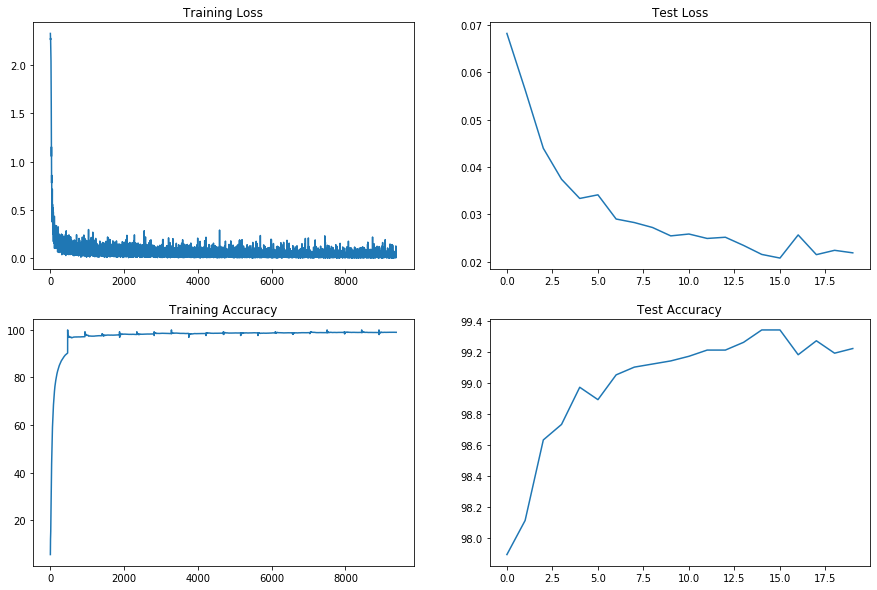

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")